## Análise de explosões solares
------

Os dados estão disponíveis em três repositórios, a lista destes repositórios esta disponível no site do projeto [RHESSI](https://hesperia.gsfc.nasa.gov/rhessi3/data-access/rhessi-data/level-0-and-quicklook-files/index.html).

A biblioteca SunPy fornece uma alternativa de acesso mais fácil a dados solares. 

------


### Testando a forma de acesso

O código abaixo é idêntico ao mostrado [aqui](https://docs.sunpy.org/en/latest/_downloads/3a8b152e871f5ccd2772588a970a8202/goes_hek_m25.py). O objetivo é apenas testar a biblioteca. 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

import sunpy.map
from sunpy.timeseries import TimeSeries
from sunpy.time import TimeRange, parse_time
from sunpy.net import hek, Fido, attrs as a

In [2]:
#Voce nao deveria rodar esta celula!
import warnings
warnings.filterwarnings("ignore")
#Nao funciona...

In [3]:
tr = TimeRange(['2011-06-07 04:00', '2011-06-07 12:00'])
results = Fido.search(a.Time(tr), a.Instrument('XRS'))

files = Fido.fetch(results)
goes = TimeSeries(files)

<IPython.core.display.Javascript object>


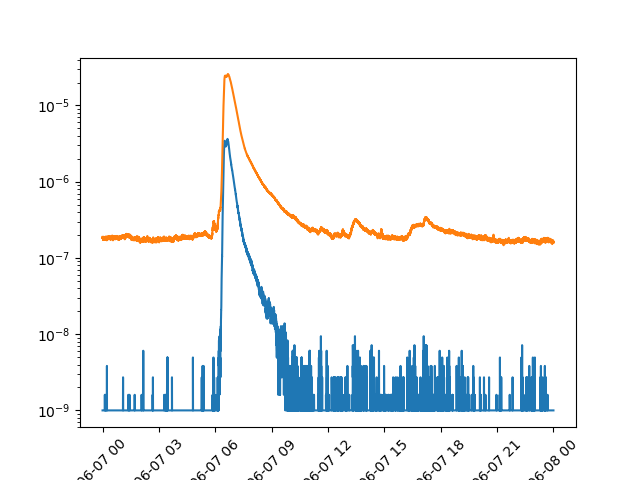

In [4]:
df = goes.data
plt.semilogy(df)
plt.xticks(rotation=45)
plt.show()

## Instrumentos de observação
------
Há diversos instrumentos de observação da atividade solar disponíveis. A lista completa de instrumentos está descrita [aqui](https://sdac.virtualsolar.org/cgi/show_details?keyword=INSTRUMENT).

O exemplo abaixo mostra um exemplo de imagem


In [5]:
tr = TimeRange(['2011-06-07 04:00', '2011-06-07 04:01'])
results = Fido.search(a.Time(tr), a.Instrument("aia"))

files = Fido.fetch(results)

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)


<IPython.core.display.Javascript object>


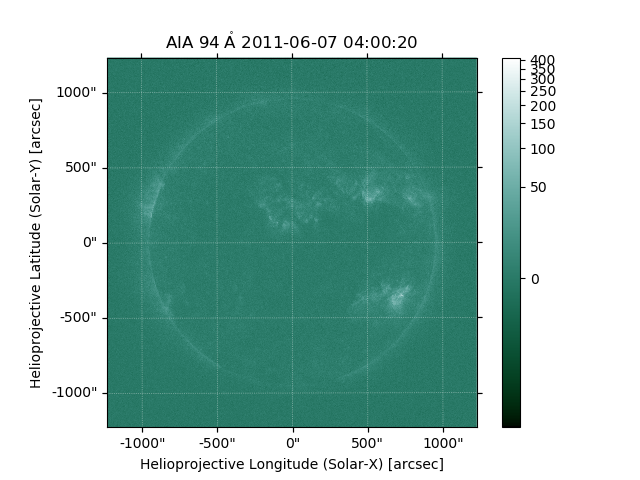

In [6]:
img = sunpy.map.Map(files[0])
img.peek()

-----
## Catálogo de explosões solares

Há diversos catálogos de explosões solares, cada um com um conjunto de propriedades diferentes. O catálogo do projeto [Hinode](https://hinode.isee.nagoya-u.ac.jp/flare_catalogue/) foi utilizado neste projeto.

Para simplificar o problema, uma versão csv do catálogo foi salva na pasta 'data/Hinode_Flare_Catalogue.csv'. Este catálogo é constantemente atualizado, e portanto, é interessante sempre atualizar o arquivo.

In [8]:
catalogo = pd.read_csv("data/Hinode_Flare_Catalogue.csv", sep = ",",engine="python")
catalogo

,Event number,start,peak,end,AR location,X-ray class,FG,SP,XRT,EIS,DARTS,RHESSI,Suzaku/WAM,NoRH
0,160620,2017/09/06 11:53,2017/09/06 12:02,2017/09/06 12:10,S09W34,X9.3,0,6,158,7,NaN,50-100,NaN,NaN
1,2750,2006/12/05 10:18,2006/12/05 10:35,2006/12/05 10:45,S06E59,X9.0,0,0,0,0,NaN,25-50,4.820000e+02,NaN
2,161170,2017/09/10 15:35,2017/09/10 16:06,2017/09/10 16:31,S08W88,X8.2,0,0,315,6,NaN,100-300,NaN,NaN
3,41780,2011/08/09 07:48,2011/08/09 08:05,2011/08/09 08:08,N14W69,X6.9,0,0,59,0,NaN,25-50,1.822000e+03,NaN
4,2960,2006/12/06 18:29,2006/12/06 18:47,2006/12/06 19:00,S05E57,X6.5,30,1,0,0,NaN,300-800,4.860000e+02,NaN
5,55910,2012/03/07 00:02,2012/03/07 00:24,2012/03/07 00:40,N18E31,X5.4,6,10,296,0,NaN,no,1.976000e+03,NaN
6,99830,2014/02/25 00:39,2014/02/25 00:49,2014/02/25 01:03,S12E82,X4.9,0,0,0,0,NaN,12-25,NaN,20140225_0043
7,3680,2006/12/13 02:14,2006/12/13 02:40,2006/12/13 02:57,S07W22,X3.4,44,1,44,1,NaN,100-300,4.930000e+02,20061213_0247
8,92040,2013/11/05 22:07,2013/11/05 22:12,2013/11/05 22:15,S12E46,X3.3,0,0,0,0,NaN,no,1.311052e+11,NaN
9,83010,2013/05/14 00:00,2013/05/14 01:11,2013/05/14 01:20,N08E77,X3.2,0,0,102,0,NaN,12-25,NaN,20130514_0107


## Limpeza
-------

Trataremos de séries temporais de explosões da classe X. Muita informação não é util para a análise, e portanto será descartada.  

In [9]:
tidy = catalogo[['start','peak', 'end','X-ray class']] 
tidy = tidy.rename(columns={"X-ray class":"class"})
tidy = tidy[tidy['class'].str.contains('X')]
tidy

,start,peak,end,class
0,2017/09/06 11:53,2017/09/06 12:02,2017/09/06 12:10,X9.3
1,2006/12/05 10:18,2006/12/05 10:35,2006/12/05 10:45,X9.0
2,2017/09/10 15:35,2017/09/10 16:06,2017/09/10 16:31,X8.2
3,2011/08/09 07:48,2011/08/09 08:05,2011/08/09 08:08,X6.9
4,2006/12/06 18:29,2006/12/06 18:47,2006/12/06 19:00,X6.5
5,2012/03/07 00:02,2012/03/07 00:24,2012/03/07 00:40,X5.4
6,2014/02/25 00:39,2014/02/25 00:49,2014/02/25 01:03,X4.9
7,2006/12/13 02:14,2006/12/13 02:40,2006/12/13 02:57,X3.4
8,2013/11/05 22:07,2013/11/05 22:12,2013/11/05 22:15,X3.3
9,2013/05/14 00:00,2013/05/14 01:11,2013/05/14 01:20,X3.2


---------------------------

# Funções 

Definido o conjunto de dados, os dados são obtidos conforme a célula abaixo.

In [10]:
def getTimeSeriesData(elem):
    tr = TimeRange([elem["start"], elem["end"]])
    results = Fido.search(a.Time(tr), a.Instrument('XRS'))
    files = Fido.fetch(results)
    ts = TimeSeries(files)
    return ts.data

ts = getTimeSeriesData(tidy.loc[0])

/home/rubens/anaconda3/lib/python3.7/asyncio/base_events.py:623: ResourceWarning: unclosed event loop <_UnixSelectorEventLoop running=False closed=False debug=False>
  source=self)
/home/rubens/anaconda3/lib/python3.7/inspect.py:2800: ResourceWarning: unclosed <socket.socket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.16.49.90', 38170), raddr=('198.118.248.134', 443)>
  for param in parameters))
/home/rubens/anaconda3/lib/python3.7/asyncio/selector_events.py:655: ResourceWarning: unclosed transport <_SelectorSocketTransport fd=66>
  source=self)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
/home/rubens/anaconda3/lib/python3.7/functools.py:827: UserWarning: Discarding nonzero nanoseconds in conversion
  return dispatch(args[0].__class__)(*args, **kw)
